In [270]:
# for DataFrames
import os
import numpy as np
import pandas as pd
import geopandas as gdp
import geoplot

# for graphing
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.plotly as py
import cufflinks as cfg

# for stats + stat testing
import scipy as sp
from scipy import stats 

In [2]:
# read files needed
df_rosenberg = pd.read_csv("../data/01_clean_data/rosenberg_table.csv").drop("Unnamed: 0", axis=1)
df_hof = pd.read_csv("../data/01_clean_data/hofstede_report.csv").drop("Unnamed: 0", axis=1)

In [3]:
# setting sns and matloplib styles
sns.set_style("whitegrid")
sns.set_palette("coolwarm")
sns.set_context("notebook", font_scale=1,  rc={"lines.linewidth": 1.5})

## 1. Answering the initial question

### Check out distributions of answers per country of 5 random samples
Useful to find outliers/skewness is answers and overall understanding of distributions.

Necessary to see if we continue working with the sample mean or the median for our correlation analysis. 

In [4]:
lst = df_rosenberg.sample(7)["country"].to_list()
lst

['GB', 'GB', 'IN', 'US', 'US', 'CA', 'US']

In [5]:
def distribution (lst_value):
    df_rosenberg_i = df_rosenberg.loc[df_rosenberg["country"] == i]["overall_score"] 
    return sns.distplot(df_rosenberg_i, bins=20, kde=False) 

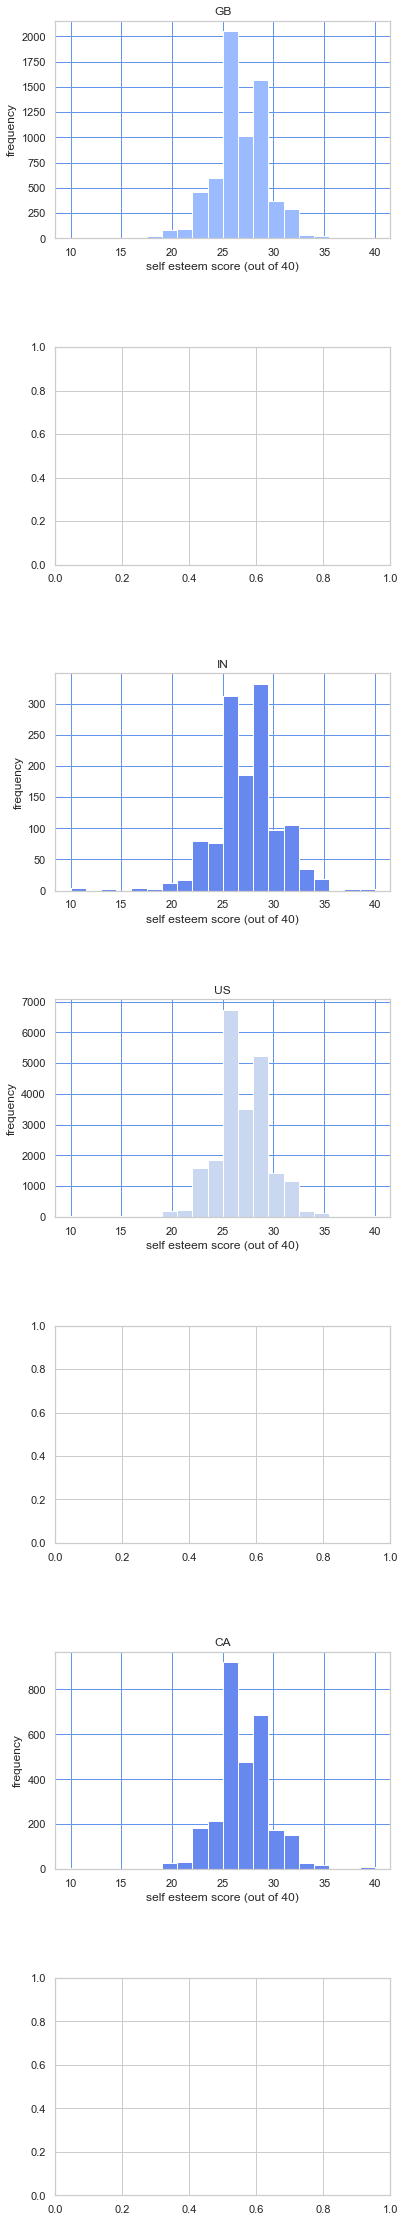

In [6]:
fig, axs = plt.subplots(7, figsize=(6,40))

for i in lst:
    df = df_rosenberg.loc[df_rosenberg["country"] == i]["overall_score"]
    axs[lst.index(i)].hist(df, bins=20)
    axs[lst.index(i)].set_title(i)
    axs[lst.index(i)].set_xlabel("self esteem score (out of 40)")
    axs[lst.index(i)].set_ylabel("frequency")
    axs[lst.index(i)].grid(axis="both", color='cornflowerblue')
    plt.subplots_adjust(hspace=0.5)

Mostly normally distributed, not many outliers, we will continue calculations using the mean of each country.

### Graphing out the mean by country

In [271]:
rosenberg_grouped = df_rosenberg.groupby(["country", "country_id"]).mean()
rosenberg_grouped.head()
df_hof.head()

,country,power_distance,individualism,country_id
0,Argentina,49.0,46.0,10
1,Australia,36.0,90.0,13
2,Austria,11.0,55.0,12
3,Bangladesh,80.0,20.0,19
4,Belgium,65.0,75.0,20


In [272]:
merge_df = rosenberg_grouped.merge(df_hof, how="left", on="country_id").dropna()
merge_df.head()

,country_id,age,overall_score,country,power_distance,individualism
2,10,23.862069,26.885057,Argentina,49.0,46.0
3,12,26.565657,27.505051,Austria,11.0,55.0
4,13,26.646316,26.718737,Australia,36.0,90.0
7,19,25.269231,26.807692,Bangladesh,80.0,20.0
8,20,26.098837,26.627907,Belgium,65.0,75.0


In [ ]:
table = pd.read_csv("../data/01_clean_data/Ice-cream-time.csv").drop("Unnamed: 0", axis=1)

In [ ]:
table = table.rename(columns={"Entity":"country"})
table.head()

In [ ]:
df = table.merge(merge_df, how="left", left_on="country", right_on="country").drop(["age", "country_id"], axis=1)
df.head()

In [ ]:
shapefile = os.path.expanduser("../../ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
colors = 9
cmap = "coolwarm"

world = geoplot.polyplot(world, figsize=(8,4))


In [ ]:
geopandas = gdp.read_file(shapefile)[["ADM0_A3", "geometry"]].to_crs("+proj=robin")
geopandas.sample(5)

### Creating the correlation table

In [8]:
rosenberg_grouped = df_rosenberg.groupby(["country", "country_id"]).mean()
rosenberg_grouped.describe()

,age,overall_score
count,86.000000,86.000000
mean,25.583268,26.899690
std,2.537350,0.473611
min,18.156250,25.468750
25%,24.038589,26.617503
50%,25.547917,26.865261
75%,27.114754,27.188384
max,32.589831,28.421053


Text(0, 0.5, 'Distribution')

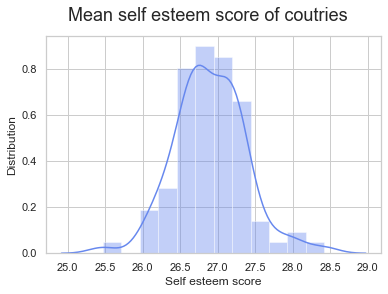

In [9]:
# initial distribution of all scores per country
figure_distribution = sns.distplot(rosenberg_grouped["overall_score"])
figure_distribution.figure.suptitle("Mean self esteem score of coutries", fontsize = 18)

plt.xlabel('Self esteem score', fontsize=12)
#plt.yticks(figure_distribution.get_yticks(), figure_distribution.get_yticks() * 100)
plt.ylabel('Distribution', fontsize=12)

### Correlation analysis

In [10]:
# merging of tables to complete correlation 
merge_df = rosenberg_grouped.merge(df_hof, how="left", on="country_id")
merge_df = merge_df.dropna()
merge_df = merge_df.rename(columns={"overall_score":"slef esteem"})
merge_df.head()

,country_id,age,slef esteem,country,power_distance,individualism
2,10,23.862069,26.885057,Argentina,49.0,46.0
3,12,26.565657,27.505051,Austria,11.0,55.0
4,13,26.646316,26.718737,Australia,36.0,90.0
7,19,25.269231,26.807692,Bangladesh,80.0,20.0
8,20,26.098837,26.627907,Belgium,65.0,75.0


In [11]:
# actual correlation table
correlations = merge_df.corr(method="pearson") 
correlations = correlations.drop(["country_id", "age"], axis=1)
correlations = correlations.drop(["country_id", "age"], axis=0)
correlations

,slef esteem,power_distance,individualism
slef esteem,1.000000,0.232530,-0.183653
power_distance,0.232530,1.000000,-0.570514
individualism,-0.183653,-0.570514,1.000000


(array([0.5, 1.5, 2.5]), <a list of 3 Text yticklabel objects>)

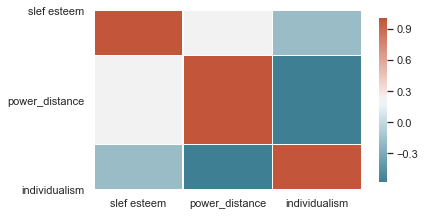

In [12]:
# correlation of overall score to cultural indicators
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(6, 6))

cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(correlations, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation=360)


### Measuring significance in difference

#### H0 and H1 testing for random samples

In [94]:
lst = merge_df.sort_values("individualism", ascending=True)
low = lst.head(10)["country"].to_list()
high = lst.tail(10)["country"].to_list()
print(low, high)


['Venezuela', 'Colombia', 'Pakistan', 'Indonesia', 'Costa Rica', 'Peru', 'Trinidad', 'Taiwan', 'Korea, Republic of', 'China'] ['Denmark', 'Belgium', 'Italy', 'New Zealand', 'Hungary', 'Canada', 'Netherlands', 'Great Britain', 'Australia', 'United States']


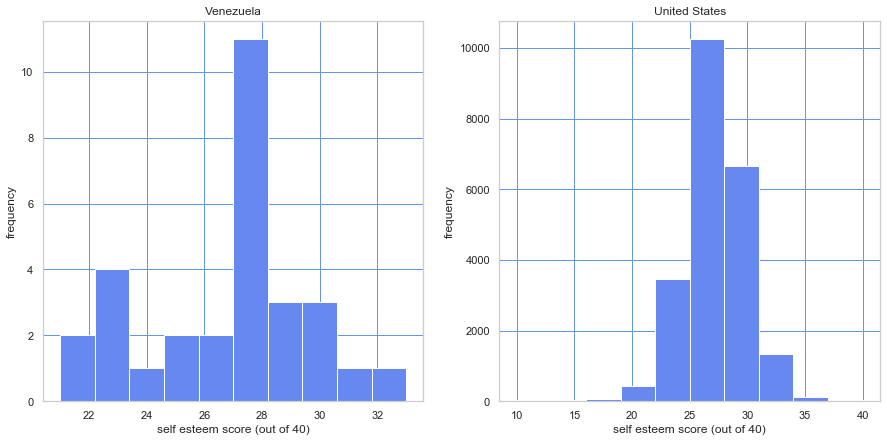

In [96]:
# test 1 
lst_2 = [239, 234]

# graphing out normal distribution:
fig, axs = plt.subplots(1, 2, figsize=(15,7))

df_0 = df_rosenberg.loc[df_rosenberg["country_id"] == 239]["overall_score"]
axs[0].hist(df_0, bins=10)
axs[0].set_title("Venezuela")
axs[0].set_xlabel("self esteem score (out of 40)")
axs[0].set_ylabel("frequency")
axs[0].grid(axis="both", color='cornflowerblue')
plt.subplots_adjust(hspace=0.5)

df_1 = df_rosenberg.loc[df_rosenberg["country_id"] == 234]["overall_score"]
axs[1].hist(df_1, bins=10)
axs[1].set_title("United States")
axs[1].set_xlabel("self esteem score (out of 40)")
axs[1].set_ylabel("frequency")
axs[1].grid(axis="both", color='cornflowerblue')
plt.subplots_adjust(hspace=0.5)

To test we use a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. 
We can use this test, if we observe two independent samples from the same or different population. The test measures whether the average (expected) value differs significantly across samples. 

If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores.

(information from the scipy.prg documentation page for the ttest_ind)

In [108]:
# actual testing
# VENEZUEL (low) vs. USA (high)
sample_1 = df_rosenberg.loc[df_rosenberg["country_id"] == 239]["overall_score"]
sample_2 = df_rosenberg.loc[df_rosenberg["country_id"] == 234]["overall_score"]

# asuming alpha = 0.05
print(stats.ttest_ind(sample_1, sample_2, equal_var=False)))

print("p value > a, H0 CANNOT BE REJECTED")

Ttest_indResult(statistic=0.2859604898576397, pvalue=0.7749110229413874)
p value > a, H0 CANNOT BE REJECTED


In [109]:
# repeting the test to avoid errors
# Bulgaria (low) vs. Poland (high)
sample_1 = df_rosenberg.loc[df_rosenberg["country_id"] == 22]["overall_score"]
sample_2 = df_rosenberg.loc[df_rosenberg["country_id"] == 180]["overall_score"]

# asuming alpha = 0.05
print(stats.ttest_ind(sample_1, sample_2, equal_var=False))

print("p value < a, H0 CANNOT BE REJECTED")

Ttest_indResult(statistic=0.34662966066688233, pvalue=0.7293027876257782)
p value < a, H0 CANNOT BE REJECTED


In [112]:
# repeting the test to avoid errors
#China (low) vs. Benmark  (high)

sample_1 = df_rosenberg.loc[df_rosenberg["country_id"] == 48]["overall_score"]
sample_2 = df_rosenberg.loc[df_rosenberg["country_id"] == 59]["overall_score"]

# asuming alpha = 0.05
print(stats.ttest_ind(sample_1, sample_2, equal_var=False))

print("p value < a, H0 CAN BE REJECTED")

Ttest_indResult(statistic=1.9979683297224777, pvalue=0.04750018000613339)
p value < a, H0 CAN BE REJECTED


##### Overall, H0 cannot be rejected, making my suggestion that self esteem and individualism are linked false (with a 95% confidence)

#### Changing H0 to power distance will have a effect on self esteem

In [88]:
lst = merge_df.sort_values("power_distance", ascending=True)
low = lst.head(10)["country_id"].to_list()
high = lst.tail(10)["country_id"].to_list()
print(low, high)

[12, 104, 59, 172, 103, 198, 168, 71, 43, 78] [102, 48, 19, 239, 158, 190, 192, 178, 159, 203]


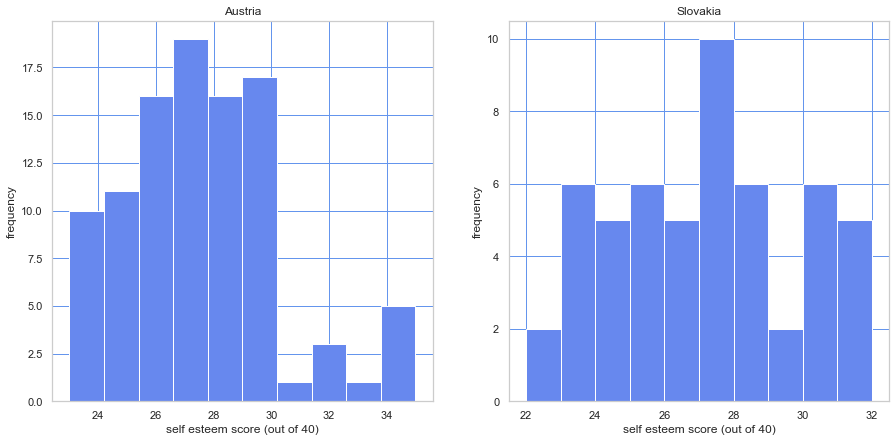

In [116]:
# graphing out normal distribution:
fig, axs = plt.subplots(1, 2, figsize=(15,7))

df_0 = df_rosenberg.loc[df_rosenberg["country_id"] == 12]["overall_score"]
axs[0].hist(df_0, bins=10)
axs[0].set_title("Austria")
axs[0].set_xlabel("self esteem score (out of 40)")
axs[0].set_ylabel("frequency")
axs[0].grid(axis="both", color='cornflowerblue')
plt.subplots_adjust(hspace=0.5)

df_1 = df_rosenberg.loc[df_rosenberg["country_id"] == 203]["overall_score"]
axs[1].hist(df_1, bins=10)
axs[1].set_title("Slovakia")
axs[1].set_xlabel("self esteem score (out of 40)")
axs[1].set_ylabel("frequency")
axs[1].grid(axis="both", color='cornflowerblue')
plt.subplots_adjust(hspace=0.5)

In [113]:
#Austria, Slovakia 

sample_1 = df_rosenberg.loc[df_rosenberg["country_id"] == 12]["overall_score"]
sample_2 = df_rosenberg.loc[df_rosenberg["country_id"] == 203]["overall_score"]

# asuming alpha = 0.05
print(stats.ttest_ind(sample_1, sample_2, equal_var=False))

print("p value > a, H0 CANNOT BE REJECTED")

Ttest_indResult(statistic=1.7796882836855188, pvalue=0.0781028071351058)
p value > a, H0 CANNOT BE REJECTED


In [114]:
#GB, Indonesia 

sample_1 = df_rosenberg.loc[df_rosenberg["country_id"] == 227]["overall_score"]
sample_2 = df_rosenberg.loc[df_rosenberg["country_id"] == 49]["overall_score"]

# asuming alpha = 0.05
print(stats.ttest_ind(sample_1, sample_2, equal_var=False))

print("p value >> a, H0 CANNOT BE REJECTED")

Ttest_indResult(statistic=-0.6999156665933691, pvalue=0.48600718297213485)
p value >> a, H0 CANNOT BE REJECTED


In [115]:
#Trinidad, Colombia 

sample_1 = df_rosenberg.loc[df_rosenberg["country_id"] == 78]["overall_score"]
sample_2 = df_rosenberg.loc[df_rosenberg["country_id"] == 102]["overall_score"]

# asuming alpha = 0.05
print(stats.ttest_ind(sample_1, sample_2, equal_var=False))

print("p value < a, H0 CAN BE REJECTED")

Ttest_indResult(statistic=-2.7270094931898408, pvalue=0.00707049846690765)
p value < a, H0 CAN BE REJECTED


##### H0 cannot be rejected, no effect - for two out of three samples we can say with a 95% confidence that there is no effect.

## Bonus

##### 2.1 Does gender have an influence?

In [213]:
# we select only F, M and O for this, as 0s indicate people who chose not to tell
gender_score = pd.crosstab(df_rosenberg["overall_score"], df_rosenberg["gender"])
gender_score = gender_score.drop("0", axis=1)

In [225]:
# defining each genders data
F = gender_score[["F"]]
M = gender_score[["M"]]
O = gender_score[["O"]]
gender = gender_score.reset_index() # as I will need to take out overall score
score = gender[["overall_score"]]

Text(0, 0.5, 'Frequency')

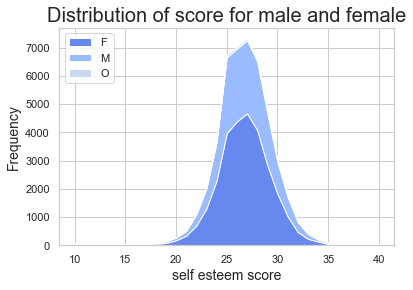

In [211]:
#plotting the distribution of slef esteem of male and female

fig, ax =  plt.subplots()

ax.stackplot(score["overall_score"], F["F"], M["M"], O["O"], labels = ["F", "M", "O"])
ax.legend(loc='upper left')

ax.set_title("Distribution of score for male and female", fontsize=20)
ax.set_xlabel('self esteem score', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

Graph not very clear for those who do not know about stats - see if another graphic can be made - maybe with age


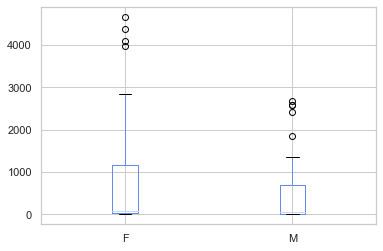

In [260]:
gender.boxplot(column=["F", "M"])


Text(188.94318181818178, 0.5, 'Frequency')

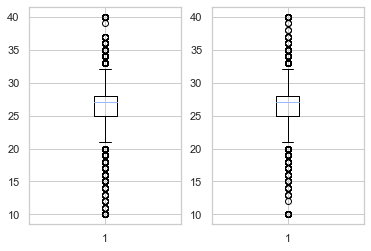

In [269]:
female = df_rosenberg[df_rosenberg["gender"] == "F"][["overall_score"]]
male =df_rosenberg[df_rosenberg["gender"] == "M"][["overall_score"]]

fig, axs =  plt.subplots(1, 2)

axs[0].boxplot(female["overall_score"], notch=False)
axs[1].boxplot(male["overall_score"], notch=False)

ax.set_title("Distribution of score for male and female", fontsize=20)
ax.set_xlabel('self esteem score', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

##### 2.2 Does age have an influence?

In [ ]:
# grouping byage + avg gives me a frequency 
rosenberg_grouped_age = df_rosenberg.groupby("age").mean()[["overall_score"]]
#rosenberg_grouped_age = rosenberg_grouped_age.drop("country", axis=1)
rosenberg_grouped_age = rosenberg_grouped_age[10:]

bins = np.linspace(df_rosenberg.age.min(), df_rosenberg.age.max(), 10)
grouped = df_rosenberg.groupby(pd.cut(df_rosenberg.age, bins))
grouped

In [ ]:
x = rosenberg_grouped_age.index
y = rosenberg_grouped_age["overall_score"]

#plt.scatter(x, y, color="pink", linewidth = .05)
#sns.boxplot(data=data)

sns.stripplot(x=x, y=y)

In [ ]:
x = df_rosenberg["age"]
y = df_rosenberg["overall_score"]

plt.scatter(x, y, color="pink", linewidth = .05)

### Is  the difference significant?
#### H0 and H1 testing